In [ ]:
# default_exp patrones_espacio_temporales

In [ ]:
# export
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from criminologia_cdmx.etl import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# patrones_espacio_temporales

> Métodos para explorar los patrones espacio-temporales de la delincuencia y su evolución

* Hotspots con KDE
* Significancia de hotspots (https://doi.org/10.1080/13658816.2017.1406943)


## kde2D

## construye_malla

In [ ]:
# export
def construye_malla(datos, size):
    """ Regresa una malla (np.meshgrid) ajustada al extent de los datos, 
        con el tamaño de celda especificado.
        
        Args:
            datos (GeoDataFrame): carpetas o víctimas
            size (float): tamaño de las celdas (en las unidades de la proyección)
        
    """
    xmin, ymin, xmax, ymax = datos.geometry.total_bounds
    xgrid = np.arange(xmin, xmax, size)
    ygrid = np.arange(ymin, ymax, size)
    X, Y = np.meshgrid(xgrid, ygrid)
    return (X, Y)

In [ ]:
carpetas = get_carpetas_from_api(10000)
carpetas = carpetas.to_crs(32614)
malla = construye_malla(carpetas, 200)

## ajusta_bandwidth_kde

In [ ]:
# exports
def ajusta_bandwidth_kde(datos, bandwidth_space, size=1000, 
                         malla=None, n_jobs=-1, metric="euclidean"):
    """ Regresa el valor de bandwidth con mejor log likelihood.

        Parametros:
        
            datos (GeoDataFrame):  víctimas o carpetas
            bandwith_space (np.linspace):  con el espacio de búsqueda
            size (float): Tamaño de la celda (en las unidades de la proyección).
                          Si se especifica malla se ignora
            malla (np.meshgrid): la malla en la que se va a ajustar el KDE, si es None se calcula
            n_jobs (int): número de procesos a usar (default = -1)
            metric (str): métrica a usar para calcular las distancias (default euclidean)
    """
    if malla is None:
        xx, yy = construye_malla(datos, size)
    else:
        xx = malla[0]
        yy = malla[1]        
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    x = datos.geometry.x.to_numpy()
    y = datos.geometry.y.to_numpy()
    xy_train  = np.vstack([y, x]).T
    grid = GridSearchCV(KernelDensity(metric=metric), bandwidth_space, n_jobs=n_jobs)
    grid.fit(xy_train)
    return grid.best_estimator_.bandwidth

Esta función ajusta el ancho de banda para calcular un KDE en 2 dimensiones. Puede ser muy tardado.

El ancho de banda se puede calcular en cualquyier sistema de coordenadas, sin embargo es conveniente proyectarlos a coordenadas planas.

Primero ajustamos especificando el tamaño de la malla

In [ ]:
params = {'bandwidth': np.linspace(10, 10000, 100)}
bw = ajusta_bandwidth_kde(carpetas, params, size=1000)
print(bw)

312.72727272727275


También podemos especificar la malla primero

In [ ]:
params = {'bandwidth': np.linspace(10, 10000, 100)}
bw = ajusta_bandwidth_kde(carpetas, params, malla=malla)
print(bw)

312.72727272727275


## kde2D

Regresa la superficie del KDE con los parámetros especificados

In [ ]:
# export

def kde2D(datos, bandwidth, size=1000, malla=None):
    """ Regresa una matriz con la densidad de kernel para los datos.

        Parametros:
        
            datos (GeoDataFrame):  víctimas o carpetas
            bandwith: ancho del kernel gaussiano
            size (float): Tamaño de la celda (en las unidades de la proyección).
                          Si se especifica malla se ignora
            metric (str): métrica a usar para calcular las distancias (default euclidean)
            malla (np.meshgrid): la malla en la que se va a ajustar el KDE, si es None se calcula
    """    
    x = datos.geometry.x.to_numpy()
    y = datos.geometry.y.to_numpy()
    if malla is None:
        X, Y = construye_malla(datos, size)
    else:
        X = malla[0]
        Y = malla[1]
    XY = np.vstack([Y.ravel(), X.ravel()]).T
    xy_train = np.vstack([y, x]).T
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(xy_train)
    Z = np.exp(kde.score_samples(XY))
    return X, Y, np.reshape(Z, X.shape)

Si no mandamos una malla como argumento, se calcula utilizando `size`

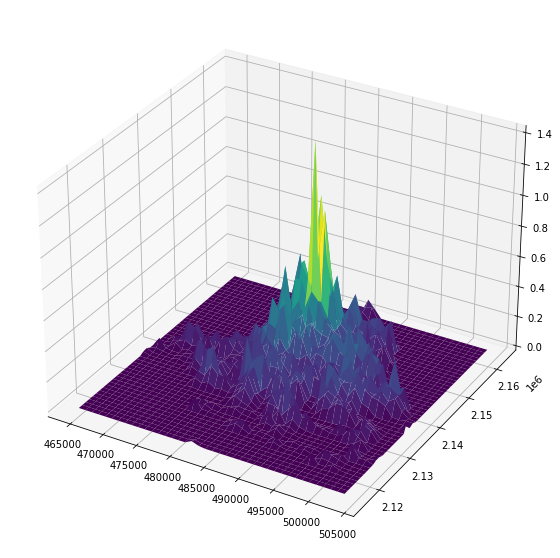

In [ ]:
# xx, yy, zz = kde2D(x, y, bw, xbins=1000j, ybins=1000j)
xx, yy, zz = kde2D(carpetas, bw, size=1000)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax = ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

También se puede especificar una malla con el tamaño deseado y calcular el KDE

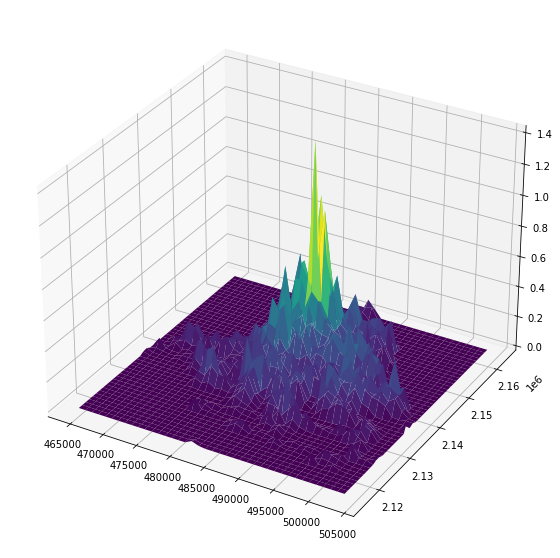

In [ ]:
malla = construye_malla(carpetas, 1000)
xx, yy, zz = kde2D(carpetas, bw, malla=malla)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax = ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

## serie_tiempo_kde_categoria

In [ ]:
# export
def serie_tiempo_kde_categoria(carpetas, fechas, categorias, offset, size,
                               grid_search={'bandwidth': np.linspace(10, 10000, 100)},
                               bw=None):
    """ Ajusta kdes egregando los datos sobre cada categoria e intervalo de fecha.

       Args:
           carpetas: Las carpetas de investigación (preprocesadas)
           fechas: lista de fechas con los extremos de los intervalos
           categorias: Lista de categorías para calcular el KDE
           offset: intervalo para agregar antes de la primera fecha, p.ej: "30 days" si los intervalos son mensuales
           size (float): Tamaño de la celda (en las unidades de la proyección)
           grid_search: {'bandwidth': np.linspace(0.001, 0.1, 100)} valores para ajustar el bandwidth (se usa sólo si bandwidth es nulo)
           bandwidth: Si no se especifica grid_search, se tiene que dar un valor de bandwidth
           **kwargs: argumentos extra que se pasan a `kde2D`

       returns:
       (xx, yy) [zz]: la tupla (xx, yy) es el grid común de los kdes, la lista contiene los valores de z para cada intervalo
    """
    kdes = []
    fecha_inicio = fechas[0] - pd.to_timedelta(offset)
    for i, fecha in enumerate(fechas):
        # TODO: paralelizar este loop
        if i == 0:
            datos_intervalo = carpetas.loc[(carpetas['fecha_hechos'].between(fecha_inicio, fecha, inclusive='left')) &
                                           (carpetas['categoria'].isin(categorias))]
        else:
            datos_intervalo = carpetas.loc[(carpetas['fecha_hechos'].between(fechas[i-1], fecha, inclusive='left')) &
                                           (carpetas['categoria'].isin(categorias))]
        if bw is None:
            bw = ajusta_bandwidth_kde(datos_intervalo, size, grid_search)
        xx, yy, zz = kde2D(datos_intervalo, bw, size)
        kdes.append(zz)
    return xx, yy, kdes

In [ ]:
carpetas = get_historico_carpetas()
carpetas = agregar_categorias_carpetas(carpetas)
carpetas = carpetas.to_crs(32614)
fechas = pd.date_range(start='1/1/2020', end='3/1/2020', freq='M').to_list()
xx, yy, kdes = serie_tiempo_kde_categoria(carpetas, fechas, 
                                          ["Homicidios dolosos"], "30 days", 500, bw=300)
assert type(kdes[0]) == np.ndarray

In [ ]:
l = [a.shape for a in kdes]
l

[(98, 83), (81, 75)]

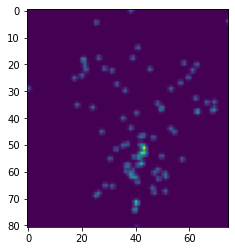

In [ ]:
plt.imshow(kdes[1])

## serie_razones_de_eventos

In [ ]:
# export
def serie_razones_de_eventos(carpetas, fechas, categoria, offset, size, bw):
    """Regresa el mapa de razón entre una categoría con respecto a las demás."""
    xx, yy, kdes_categoria = serie_tiempo_kde_categoria(carpetas, fechas, [categoria],
                                                        offset, size, bw=bw)
    categorias_todas = list(carpetas[carpetas.categoria.notnull()]['categoria'].unique())
    categorias_todas.remove(categoria)
    xx, yy, kdes_base = serie_tiempo_kde_categoria(carpetas, fechas, 
                                                   categorias_todas, offset, size, bw=bw)
    # TODO: vectorizar esta operación np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    serie_razones = [np.divide(np.round(e, 5), 
                               np.round(b, 5), 
                               out=np.zeros_like(e), 
                               where=np.round(b, 5)!=0) 
                     for e, b in zip(kdes_categoria, kdes_base)]
    return serie_razones
    # return kdes_base

In [ ]:
serie_razones = serie_razones_de_eventos(carpetas, 
                                         fechas, 
                                         "Homicidios dolosos", 
                                         "30 days", 
                                         500,
                                         bw)

ValueError: operands could not be broadcast together with shapes (98,83) (100,83) (98,83) (100,83) 

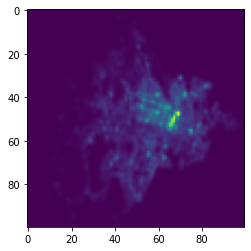

In [ ]:
plt.imshow(serie_razones[0])

````Python
%%time
serie_razones = serie_razones_de_eventos(carpetas, 
                                         fechas, 
                                         "Homicidios dolosos", 
                                         "30 days", 
                                         bw=0.001)
````

## serie_mapas_intensidad

In [ ]:
# export
def serie_mapas_intensidad(carpetas, fechas, categoria, offset, **kwargs):
    """Regresa los mapas de razon y las intensidades de la categoría para las `fechas` seleccionadas."""
    razones = serie_razones_de_eventos(carpetas, fechas, categoria, offset, **kwargs)
    avg = np.round(np.mean(razones, axis=0), 5)
    std = np.round(np.std(razones, axis=0), 5)
    intensidad = [np.divide(r - avg, std, out=np.zeros_like(r), where=std!=0) for r in razones]
    return razones, intensidad

In [ ]:
razones, intensidades = serie_mapas_intensidad(carpetas, 
                                               fechas,
                                               'Homicidios dolosos',
                                               "30 days", bw=1500)

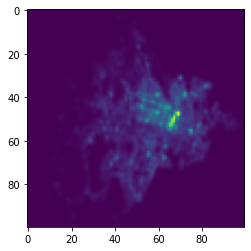

In [ ]:
plt.imshow(razones[0])

## p_value_maps

In [ ]:
# export
def p_value_maps(razones):
    """Regresa los mapas de significancia estadística para las razones."""
    p_values = []
    for r in razones:
        comp = [b >= r for b in razones]
        comp = np.sum(comp, axis=0)
        p = comp / (len(razones) + 1)
        p_values.append(p)
    return p_values

In [ ]:
significancias = p_value_maps(razones)